In [37]:
import sirius, json
import numpy as np
from sirius_md import cpmd_verlet, verlet
from itertools import islice
import pandas as pa
import matplotlib.pyplot as plt

## Unit cell with 2 Si atoms

In [2]:
# create unit cell and sirius context, compute groundstate using SCF
def init():
    lat = 10.26* np.eye(3)
    gk_cutoff = 6
    pw_cutoff = 12
    inp={
        "parameters" : {
            "xc_functionals" : ["XC_LDA_X", "XC_LDA_C_PZ"],
            "electronic_structure_method" : "pseudopotential",
            "pw_cutoff" : pw_cutoff,
            "gk_cutoff" : gk_cutoff,
            "num_fv_states": 4,
            "use_symmetry": True,
            "gamma_point": False
        },
        "control" : {
            "verbosity" : 0
        }
    }
    ctx = sirius.Simulation_context(json.dumps(inp))
    ctx.unit_cell().set_lattice_vectors(*lat)
    ctx.unit_cell().add_atom_type('Si','pseudos/Si.json')
    ctx.unit_cell().add_atom('Si', [0,0,0])
    ctx.unit_cell().add_atom('Si', [0.25,]*3)
    ctx.initialize()
    kset = sirius.K_point_set(ctx, [1,1,1], [0,0,0], True)
    dft = sirius.DFT_ground_state(kset)
    dft.initial_state()
    tol = 1e-9
    dft_gs = dft.find(tol, tol, tol, 1000, False)
    return kset

In [25]:
x0 = sirius.atom_positions(kset1.ctx().unit_cell())
v0 = np.zeros_like(x0)

# Car-Parinello
cpmd_params = {
    'parameters': {
        'dt': 5, 
        'me': 600, 
        'T': 300
    }
}

# Born-Oppenheimer MD (orbital transformation method)
bomd_params = {
    'parameters': {
       'method': {'type': 'plain'}, 
    'solver': 'ot', 
    'maxiter': 100, 
    'dt': 5, 
    'density_tol': 1e-8,
    'energy_tol': 1e-8
    }
}

# MD generators
cpmd_gen = cpmd_verlet.cpmd_verlet_raw(cpmd_params, init())
bomd_gen = verlet.velocity_verlet_raw(bomd_params, init())

# run BOMD velocity verlet and Car-Parinello MD, evaluate first 1000 timesteps
res_cpmd = list(islice(cpmd_gen, 1000))
res_bomd = list(islice(bomd_gen, 1000))

In [41]:
cpmd = pa.DataFrame(res_cpmd)
bomd = pa.DataFrame(res_bomd)

Text(0, 0.5, 'Interatomic distance [Å]')

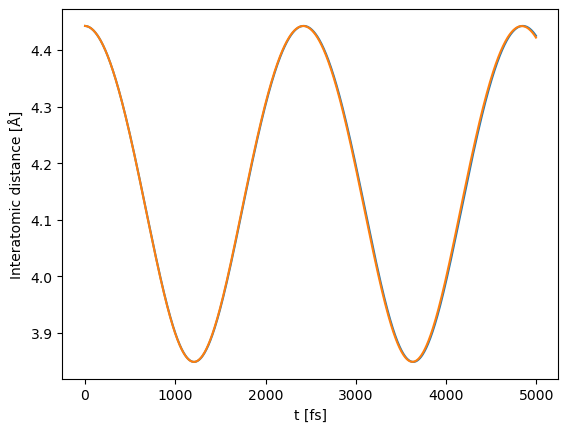

In [72]:
dist = lambda x: np.linalg.norm(x[0]-x[1])

plt.plot(cpmd['t'], cpmd['x'].apply(dist))
plt.plot(bomd['t'], bomd['x'].apply(dist))
plt.xlabel('t [fs]')
plt.ylabel('Interatomic distance [Å]')

Text(0, 0.5, 'Error [Å]')

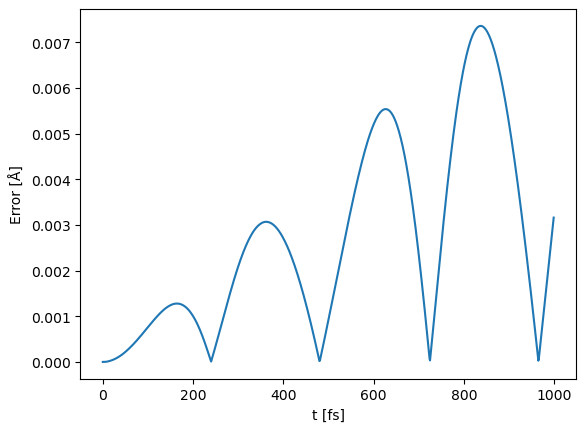

In [64]:
plt.plot(np.abs(cpmd['x'].apply(dist) - bomd['x'].apply(dist)))
plt.xlabel('t [fs]')
plt.ylabel('Error [Å]')

Text(0, 0.5, 'E [Ha]')

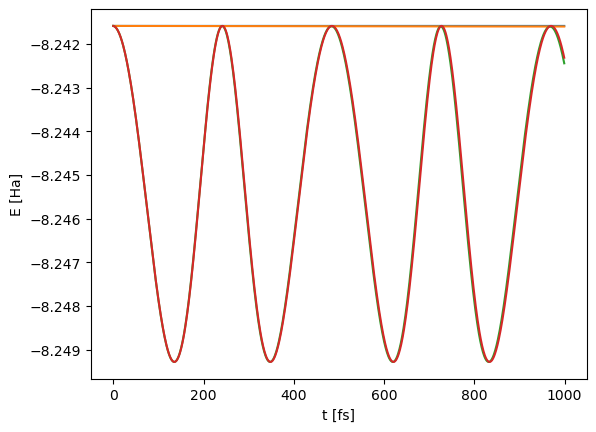

In [66]:
plt.plot(cpmd['E'], label='cpmd')
plt.plot(bomd['E'], label='bomd')
plt.plot(bomd['EKS'], label='bomd')
plt.plot(cpmd['EKS'], label='bomd')
plt.xlabel('t [fs]')
plt.ylabel('E [Ha]')